In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%cd ..

/home/ubuntu/sustaingym


In [2]:
import argparse
from datetime import datetime
import os
import string
from typing import Callable

import pandas as pd
from ray.rllib.algorithms import a2c, ppo, sac
from ray.tune.registry import register_env

from sustaingym.envs.evcharging import EVChargingEnv, RealTraceGenerator, \
    GMMsTraceGenerator, DiscreteActionWrapper, MultiAgentEVChargingEnv
from sustaingym.algorithms.evcharging.baselines import RLLibAlgorithm
from sustaingym.envs.evcharging.event_generation import AbstractTraceGenerator
from sustaingym.envs.evcharging.utils import DATE_FORMAT, DEFAULT_PERIOD_TO_RANGE, SiteStr


###
SAMPLE_EVAL_PERIODS = {
    'Summer 2019':   ('2019-07-01', '2019-07-14'),
    'Fall 2019':     ('2019-11-04', '2019-11-17'),
    'Spring 2020':   ('2020-04-06', '2020-04-19'),
    'Summer 2021':   ('2021-07-05', '2021-07-18'),
}

ENV_NAME = "evcharging"

SPB = 10_000  # steps per batch
TOTAL_STEPS = 250_000  # 10_000
EVAL_EPISODES = 14  # 2
RLLIB_PATH = 'logs/RLLib'
TRAIN_RESULTS, TEST_RESULTS = 'train_results.csv', 'test_results.csv'


def parse_args() -> dict:
    """Parse command line arguments."""
    parser = argparse.ArgumentParser(
        description='train RLLib models on EVChargingEnv',
        formatter_class=argparse.ArgumentDefaultsHelpFormatter)
    parser.add_argument(
        '-a', '--algo', type=str, default='ppo',
        help="'ppo', 'a2c', or 'sac'")
    parser.add_argument(
        '-t', '--train_date_period', type=str, nargs='+', default='Summer 2019',  ##
        help="Season. 'Summer 2019', 'Fall 2019', 'Spring 2020', 'Summer 2021'")
    parser.add_argument(
        '-s', '--site', type=str, default='caltech',
        help='site of garage. caltech or jpl')
    parser.add_argument('-d', '--discrete', action=argparse.BooleanOptionalAction)
    parser.add_argument('-m', '--multiagent', action=argparse.BooleanOptionalAction)
    parser.add_argument(
        '-p', '--periods_delay', type=int, default=0,
        help='communication delay in multiagent setting. Ignored for single agent.')
    parser.add_argument(
        '-r', '--seed', type=int, default=0,
        help='Random seed')
    args = parser.parse_args()

    config = {
        "algo": args.algo,
        "dp": ' '.join(args.train_date_period),
        "site": args.site,
        "discrete": args.discrete,
        "multiagent": args.multiagent,
        "periods_delay": args.periods_delay,
        "seed": args.seed
    }
    print("Config: ", config)
    return config


def num_days_in_period(full: bool, dp: str) -> int:
    """Returns the number of days in period."""
    d = DEFAULT_PERIOD_TO_RANGE if full else SAMPLE_EVAL_PERIODS
    dts = tuple(datetime.strptime(x, DATE_FORMAT) for x in d[dp])
    return (dts[1] - dts[0]).days + 1

def config_to_str(config: dict) -> str:
    s = str(config)
    savedir = s.translate(str.maketrans('', '', string.punctuation + ' '))
    return savedir

def read_experiment(env_config: dict) -> tuple[pd.DataFrame, pd.DataFrame]:
    s = config_to_str(env_config)
    train_results_df = pd.read_csv(os.path.join(RLLIB_PATH, s, TRAIN_RESULTS), index_col=0)
    test_results_df = pd.read_csv(os.path.join(RLLIB_PATH, s, TEST_RESULTS), index_col=0)
    return train_results_df, test_results_df

In [5]:
train_results_df, test_results_df = read_experiment({
        "algo": 'ppo',
        "dp": 'Summer 2019',
        "site": 'caltech',
        "discrete": None,
        "multiagent": None,
        "periods_delay": 0,
        "seed": 123
})

Save to: 'plots/training_curves_separate_rllib.png'


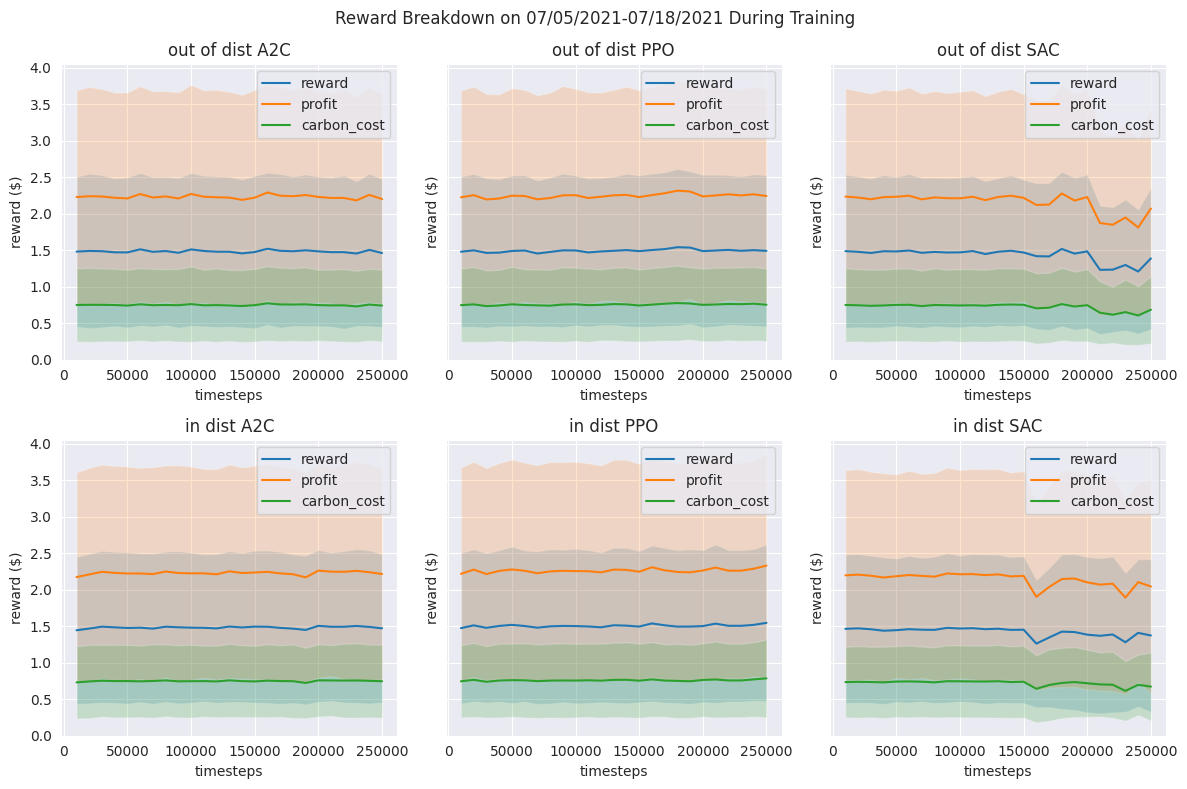

In [23]:
def plot_experiments():
    import ast
    import matplotlib.pyplot as plt
    import numpy as np
    import seaborn as sns
    sns.set_style('darkgrid')

    fig, axes = plt.subplots(2, 3, figsize=(12, 8), sharey=True)

    algos = ['a2c', 'ppo', 'sac']
    dps = ['Summer 2019', 'Summer 2021']
    seeds = [123, 246, 369]
    timesteps = list(range(1 * 10000, 26 * 10000, 10000))

    config = {
        "algo": 'ppo', "dp": 'Summer 2019',
        "site": 'caltech', "discrete": None, "multiagent": None,
        "periods_delay": 0, "seed": 123
    }

    best_seeds = {}
    for algo in algos:
        for dp in dps:
            config['algo'], config['dp'] = algo, dp
            for seed in seeds:
                config['seed'] = seed
                _, test_results_df = read_experiment(config)
                mean = test_results_df['reward'].mean()
                if (algo, dp) not in best_seeds or mean > best_seeds[(algo, dp)][1]:
                    best_seeds[(algo, dp)] = seed, mean

    for i, algo in enumerate(algos):
        for j, dp in enumerate(dps):
            seed = best_seeds[(algo, dp)][0]
            config['algo'], config['dp'], config['seed'] = algo, dp, seed

            train_results_df, test_results_df = read_experiment(config)
            mean = test_results_df['reward'].mean()
            
            dist = 'out of dist' if dp == 'Summer 2019' else 'in dist'
            axes[j][i].set_title(f'{dist} {algo.upper()}')
            axes[j][i].set_ylabel('reward ($)')
            axes[j][i].set_xlabel('timesteps')

            for col in ['reward', 'profit', 'carbon_cost']:
                train_results_df[col] = train_results_df[col].apply(lambda x: np.array(ast.literal_eval(x)))
                m = train_results_df[col].apply(lambda x: x.mean())
                std = train_results_df[col].apply(lambda x: x.std())
                axes[j][i].plot(m, label=col)
                axes[j][i].fill_between(timesteps, m - std, m + std, alpha=0.2)

            axes[j][i].legend()
    
    fig.suptitle(f'Reward Breakdown on 07/05/2021-07/18/2021 During Training')
    fig.tight_layout()
    print(f"Save to: 'plots/training_curves_separate_rllib.png'")
    fig.savefig('plots/training_curves_separate_rllib.png', dpi=300, bbox_inches='tight')

plot_experiments()

                alg    reward  in_dist
0  offline\noptimal  0.385611     2021
1  offline\noptimal  0.867971     2021
2  offline\noptimal  3.088122     2021
3  offline\noptimal  2.026413     2021
4  offline\noptimal  1.096666     2021
      alg    reward  in_dist
1348  sac  0.515793     2021
1349  sac  0.708276     2021
1350  sac  3.601139     2021
1351  sac  1.937148     2021
1352  sac  0.259509     2021
Save to: 'plots/violins_caltech_Summer 2021_rllib.png'


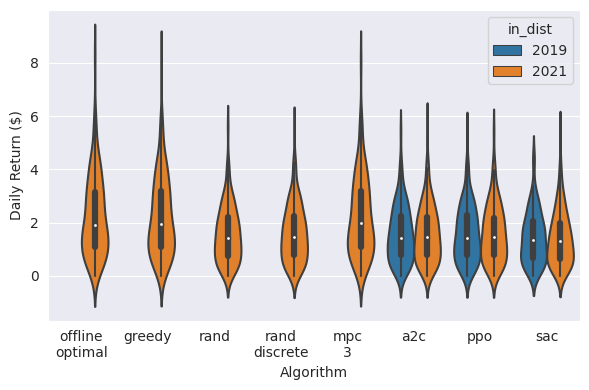

In [24]:
def plot_violins() -> None:
    """Plot violin plots for RLLib algorithms."""
    import matplotlib.pyplot as plt
    import numpy as np
    import seaborn as sns
    from sustaingym.scripts.evcharging.plot_utils import read_baseline
    from sustaingym.scripts.evcharging.train_rllib import get_best_seeds
    algs = ['offline_optimal', 'greedy', 'random', 'random_discrete']

    # Find best MPC
    best_window, best_mean_reward = 1, -100_000
    for window in [1, 3, 6, 12, 24]:
        df = read_baseline('caltech', 'Summer 2021', f'mpc_{window}')
        mean_reward = np.mean(df.reward)
        if mean_reward > best_mean_reward:
            best_window, best_mean_reward = window, mean_reward
    algs.append(f'mpc_{best_window}')

    records = []
    # Read baselines
    for alg in algs:
        df = read_baseline('caltech', 'Summer 2021', alg)
        reward = list(np.array(df.reward))
        for r in reward:
            alg_label = alg.replace('random', 'rand').replace('_', '\n')
            records.append((alg_label, r, 2021))   # baselines are neither in dist or out of dist

    # 
    best_seeds = get_best_seeds()
    config = {
        "algo": 'ppo', "dp": 'Summer 2019',
        "site": 'caltech', "discrete": None, "multiagent": None,
        "periods_delay": 0, "seed": 123
    }

    for _, (algo, dp) in enumerate(best_seeds):
        config['algo'], config['dp'], config['seed'] = algo, dp, best_seeds[(algo, dp)][0]
        _, test_results_df = read_experiment(config)
        reward = list(test_results_df['reward'])
        year = 2021 if dp == 'Summer 2021' else 2019
        for r in reward:
            records.append((algo, r, year))

    fig, ax = plt.subplots(figsize=(6, 4), tight_layout=True)
    df = pd.DataFrame.from_records(records, columns=['alg', 'reward', 'in_dist'])
    print(df.head())
    print(df.tail())
    sns.violinplot(data=df, x='alg', y='reward', hue='in_dist', ax=ax)
    ax.set(xlabel='Algorithm', ylabel="Daily Return ($)")
    # ax.set_xticklabels(algs, rotation=30)
    print(f"Save to: 'plots/violins_caltech_Summer 2021_rllib.png'")
    fig.savefig(f'plots/violins_caltech_Summer 2021_rllib.png', dpi=300, pad_inches=0)

plot_violins()